# Trabalho 5 - Transformada de Hough

## Preâmbulo

A transformada de Hough baseia-se num modelo analítico para relacionar o espaço da imagem em um conjunto de parâmetros ao converter as coordenadas dos pixels para este espaço analítico.

Este espaço analítico facilita a identificação bem como a localização de objetos geométricos na imagem original.

Cabe ressaltar que essa transformação não adminte inversa, de forma que não é possível reconstruir a imagem original tomando como base os parâmetros analíticos obtidos pela transformação.

Este modelo analítico é projetado para identificar um tipo de objeto geométrico, de forma que existirá uma transformada para identificação de retas mas será necessária outra função para a identificação de objetos com características diferentes, como é o caso do círculo.

A transformada de Hough identifica retas e encontra os pontos usando a equação reduzida da reta, a saber, $y = ax + b$, sendo $a$ o coeficiente angular e $b$ a interseção com o eixo $x$. Contudo isso apresenta um problema para a identificação de retas verticais pois nesse caso o coeficiente angular seria infinito ($a = \infty$), como alternativa foram propostos outros tipos de modelagem, como é o caso da Modelagem de Duda e Hart que utiliza a equação polar da reta.

Para este trabalho serão identificados os círculos de uma imagem de entrada e então analisados os resultados da abordagem.

## Código

O código, apresentado a seguir, é separado nos métodos:
* image_side_by_side apenas para exibir a imagem na tela;
* strel cria um elemento estruturante circular;
* abe operação de abertura;
* fec operação de fechamento;
* tophat_white transformação top-hat white;
* tophat_black transformação top-hat black;
* find_circulos encontra os círculos utilizando a transformada de Hough para círculos;
* draw_circulos desenha os círculos sobre a imagem original;
* less_circulos elimina círculos com centro muito próximo.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

np.seterr(all='raise')


def image_side_by_side(imgs, titles):
	imgs = [np.round(img).astype("uint8") for img in imgs]
# 	plt.subplot(121, figsize=(16, 10)), plt.imshow(imgs[0], cmap='gray'), plt.title(titles[0])
# 	plt.subplot(122, figsize=(16, 10)), plt.imshow(imgs[1], cmap='gray'), plt.title(titles[1])
    
	f, axarr = plt.subplots(1, len(imgs), figsize=(20, 10))
	for i in range(len(imgs)):
		axarr[i].imshow(imgs[i], cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
		if titles:
			plt.title(titles[i])
	plt.show()


def strel(radius):
	'''
	Cria um elemento estruturante em forma de círculo.
	:param radius: Raio do elemento estruturante.
	:return: O elemento estruturante.
	'''
	resp = np.zeros([2 * radius + 1, 2 * radius + 1], np.uint8)
	for i in range(2 * radius + 1):
		for j in range(2 * radius + 1):
			x = i - radius
			y = j - radius
			resp[i, j] = x * x + y * y <= radius * radius
	return resp


def abe(img, neigh):
	return cv2.dilate(cv2.erode(img, neigh, iterations=1), neigh.transpose(), iterations=1)


def fec(img, neigh):
	return cv2.erode(cv2.dilate(img, neigh, iterations=1), neigh.transpose(), iterations=1)


def tophat_white(img, neigh):
	return img - abe(img, neigh)


def tophat_black(img, neigh):
	return img - fec(img, neigh)


def find_circulos(img):
	img = np.round(img).astype("uint8")
	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	circulos = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.3, 10)
	return np.round(circulos[0, :]).astype("int") if circulos is not None else []


def draw_circulos(img, circulos, cor_circulo=(0, 255, 0), cor_centro=(0, 128, 255)):
	output = img.copy()
	print(f"Foram encontrados {len(circulos) if circulos is not None else 0} circulos")

	for (x, y, r) in circulos:
		cv2.circle(output, (x, y), r, cor_circulo, 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), cor_centro, -1)
	return output


def less_circulos(circulos, min_distance=10):
	resp = []
	for (x, y, r) in circulos:
		incluir = True
		for (x1, y1, r1) in resp:
			if math.hypot(x1 - x, y1 - y) < min_distance:
				incluir = False
				break
		if incluir:
			resp += [(x, y, r)]
	return resp

## Resultados

Para os testes foi utilizada a foto do exemplo referenciado:
https://en.wikipedia.org/wiki/Top-hat_transform#Example

Inicialmente é exibida a imagem original, e esta é cortada para remover a parte branca e facilitar a identificação dos círculos.

In [2]:
file_name = "Cosmos_original.jpg"
cosmos_img = cv2.imread(file_name)
x, y = [40, 70], [90, 90]
cosmos_img_cropped = cosmos_img[x[0]:cosmos_img.shape[0] - x[1], y[0]:cosmos_img.shape[1] - y[1]]
# image_side_by_side([cosmos_img, cosmos_img_cropped], ["Original", "Cortada"])
cosmos_img = cosmos_img_cropped

O próximo passo é aplicar o filtro tophat para identificar os círculos e então subtrair o resultado da imagem orignal de forma a ter apenas os círculos.

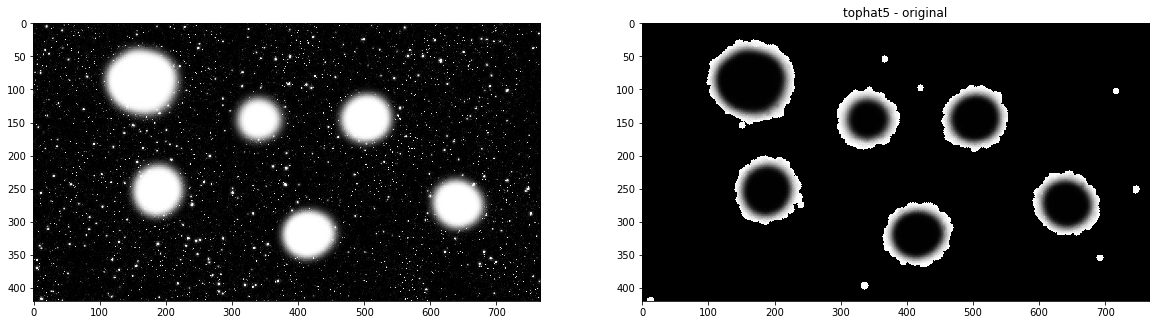

In [3]:
tophat5 = tophat_white(cosmos_img, strel(5))
# image_side_by_side([cosmos_img, tophat5], ["Original", "tophat5"])
tophat3_cosmos = tophat5 - cosmos_img
image_side_by_side([cosmos_img, tophat3_cosmos], ["Original", "tophat5 - original"])

Podemos ver abaixo a imagem original e o resultaod após aplicar a operação de detecção de bordas de laplace ao resultado do filtro top hat.

In [4]:
bordas_laplacian = cv2.Laplacian(tophat3_cosmos, cv2.CV_64F)
# image_side_by_side([cosmos_img, bordas_laplacian], ["Original", "bordas_laplacian"])

Em seguida é aplicado um threshold ao resultado da detecção de bordas pelo filtro laplaciano.

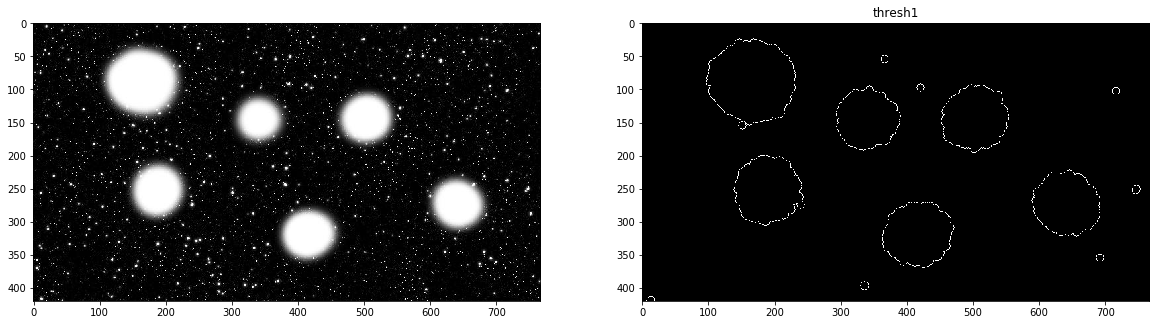

In [5]:
ret, thresh1 = cv2.threshold(bordas_laplacian, 127, 255, cv2.THRESH_BINARY)
image_side_by_side([cosmos_img, thresh1], ["Original", "thresh1"])

Agora ao resultado da aplicação do filtro laplaciano é aplicada a operação de detecção de círculos.

In [6]:
thresh1_circulos = draw_circulos(cosmos_img, find_circulos(thresh1))

Foram encontrados 0 circulos


É exibido o resultado do processo de threshold, que foi a entrada da transformada de Hough para identificação de círculos.
Conforme pode ser verificado nas imagens acima, nenhum filtro pode ser identificado.

Desta forma utiliza-se agora o resultado do filtro tophat para identificação dos filtros, a seguir é exibida a imagem de entrada para a transformada de Hough e em seguida os círculos identificados.

Foram encontrados 9 circulos


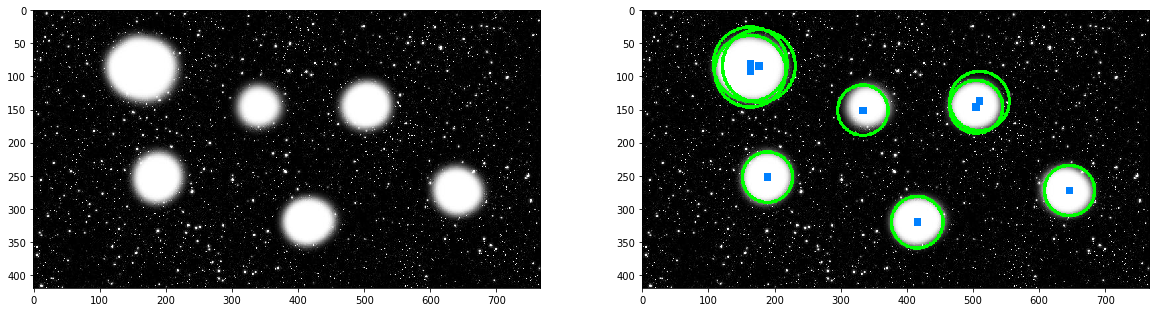

In [7]:
tophat3_circulos = find_circulos(tophat3_cosmos)
tophat3_cosmos_circulos = draw_circulos(cosmos_img, tophat3_circulos)

image_side_by_side([thresh1_circulos, tophat3_cosmos_circulos], None)
# image_side_by_side([tophat3_cosmos, tophat3_cosmos_circulos], ["tophat3_cosmos", "tophat3_cosmos_circulos"])

Conforme podemos preceber, foram identificados 9 círculos, contudo só exitem 6 na imagem original, aparentemente o método identificou círculos com centros muito próximos e raios semelhantes, desta forma foi desenvolvida a função less_circulos que identifica os círculos muito próximos e os descarta caso essa distância seja menor do que um determinado valor, uma melhoria nesse processo seria considerar também o tamanho do raio pois da forma como está implementado pode considerar que círculos concêntricos mas de raios diferentes são o mesmo.

Foram encontrados 6 circulos


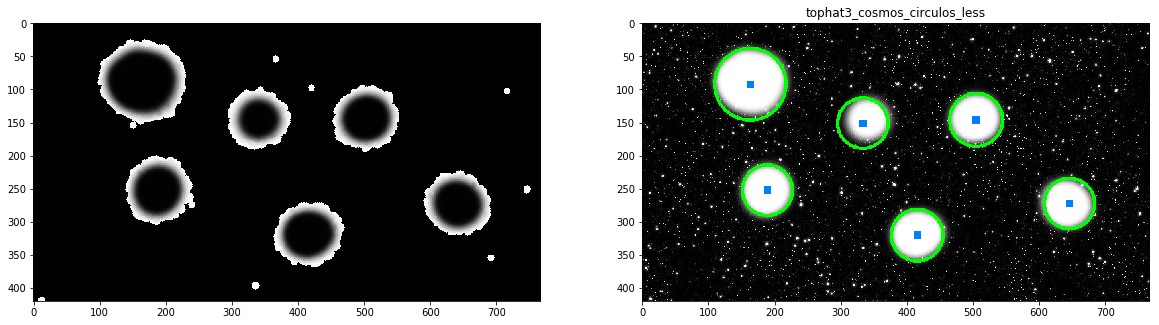

In [8]:
tophat3_circulos_less = less_circulos(tophat3_circulos, 20)
tophat3_cosmos_circulos_less = draw_circulos(cosmos_img, tophat3_circulos_less)
image_side_by_side([tophat3_cosmos, tophat3_cosmos_circulos_less], ["tophat3_cosmos", "tophat3_cosmos_circulos_less"])

Na nova abordagem foram identificados 6 círculos, um para cada objeto na imagem original, melhorando assim o resultado do método.

### Discussão

Ao comparar os resultados pode-se perceber que os a utilização do resultado da aplicação do filtro tophate obteve melhores resultados, em comparação com o threshold.
Outro ponto interessante é que o mesmo círculo foi identificado repetidas vezes mas este problema pode ser minimizado utilizando uma abordagem simples, conforme